In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## Input

In [2]:
base_path = 'Z:/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
# base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-02-06-Hongyu-Hongyu_multicap_covid_spleen_replicates1/'
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
test_path = os.path.join(output_path, "kmeans_cell_typing")
if not os.path.exists(test_path):
    os.mkdir(test_path)
    
cdata = sc.read_h5ad(os.path.join(expr_path, f'2024-03-03-combined-level3-bk.h5ad'))
rdata = sc.read_h5ad(os.path.join(expr_path, f'2024-03-03-combined-level3-region23-bk.h5ad'))

## Heatmap

In [3]:
rdata.obs['level_2_condition'] = rdata.obs['level_2'].astype(str) + '_' + rdata.obs['condition'].astype(str)
rdata.obs['level_2_condition'].unique()

array(['NA_WT', 'B cells_WT', 'T cells_WT', 'Monocytes_WT', 'Th1_WT',
       'Naive T cells_WT', 'cDC2_WT', 'Dendritic cells_WT', 'cDC1_WT',
       'CD8 T cells_WT', 'Macrophages_WT', 'Naive CD4 T cells_WT',
       'Activated Macrophages_WT', 'Th2_WT', 'Treg_WT',
       'Exhausted T cells_WT', 'CD4 T cells_WT', 'Th17_WT', 'B cells_99R',
       'Naive T cells_99R', 'cDC2_99R', 'Th1_99R', 'NA_99R', 'cDC1_99R',
       'Monocytes_99R', 'CD8 T cells_99R', 'Dendritic cells_99R',
       'Activated Macrophages_99R', 'T cells_99R', 'Macrophages_99R',
       'Naive CD4 T cells_99R', 'Exhausted T cells_99R', 'Th2_99R',
       'Treg_99R', 'Th17_99R', 'CD4 T cells_99R',
       'Activated Macrophages_33NM', 'B cells_33NM', 'Monocytes_33NM',
       'Dendritic cells_33NM', 'NA_33NM', 'T cells_33NM',
       'Macrophages_33NM', 'cDC1_33NM', 'Naive T cells_33NM', 'cDC2_33NM',
       'Th17_33NM', 'Th1_33NM', 'Treg_33NM', 'Exhausted T cells_33NM',
       'Th2_33NM', 'CD8 T cells_33NM', 'Naive CD4 T cells_3

In [4]:
level_2_order = [
    'T cells',
    'CD4 T cells',
    'CD8 T cells',
    'Treg',
    'Th1',
    'Th2',
    'Th17',
    'Naive T cells',
    'Naive CD4 T cells',
    'Exhausted T cells',

    'B cells',

    'Macrophages',
    'Activated Macrophages',
    'Monocytes',

    'Dendritic cells',
    'cDC1',
    'cDC2',

    'NA'
]

condition_order = ['WT', '99R', '33NM']

In [5]:
level_2_condition_order = []

for i in level_2_order:
    for j in condition_order:
        level_2_condition_order.append(f"{i}_{j}")

rdata.obs['level_2_condition'] = rdata.obs['level_2_condition'].astype('category')
rdata.obs['level_2_condition'] = rdata.obs['level_2_condition'].cat.reorder_categories(level_2_condition_order)

B cells


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\scanpy\plotting\_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


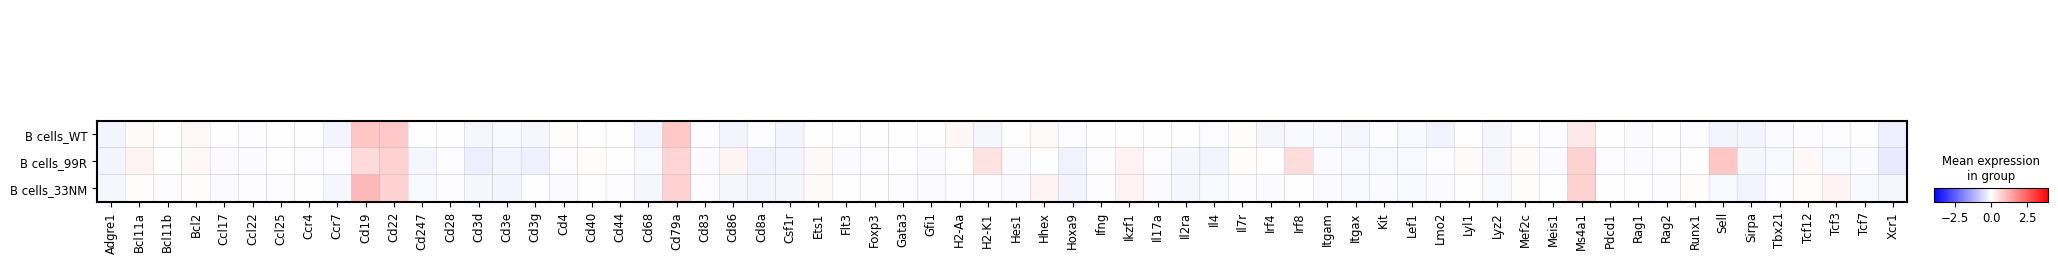

T cells


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\scanpy\plotting\_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


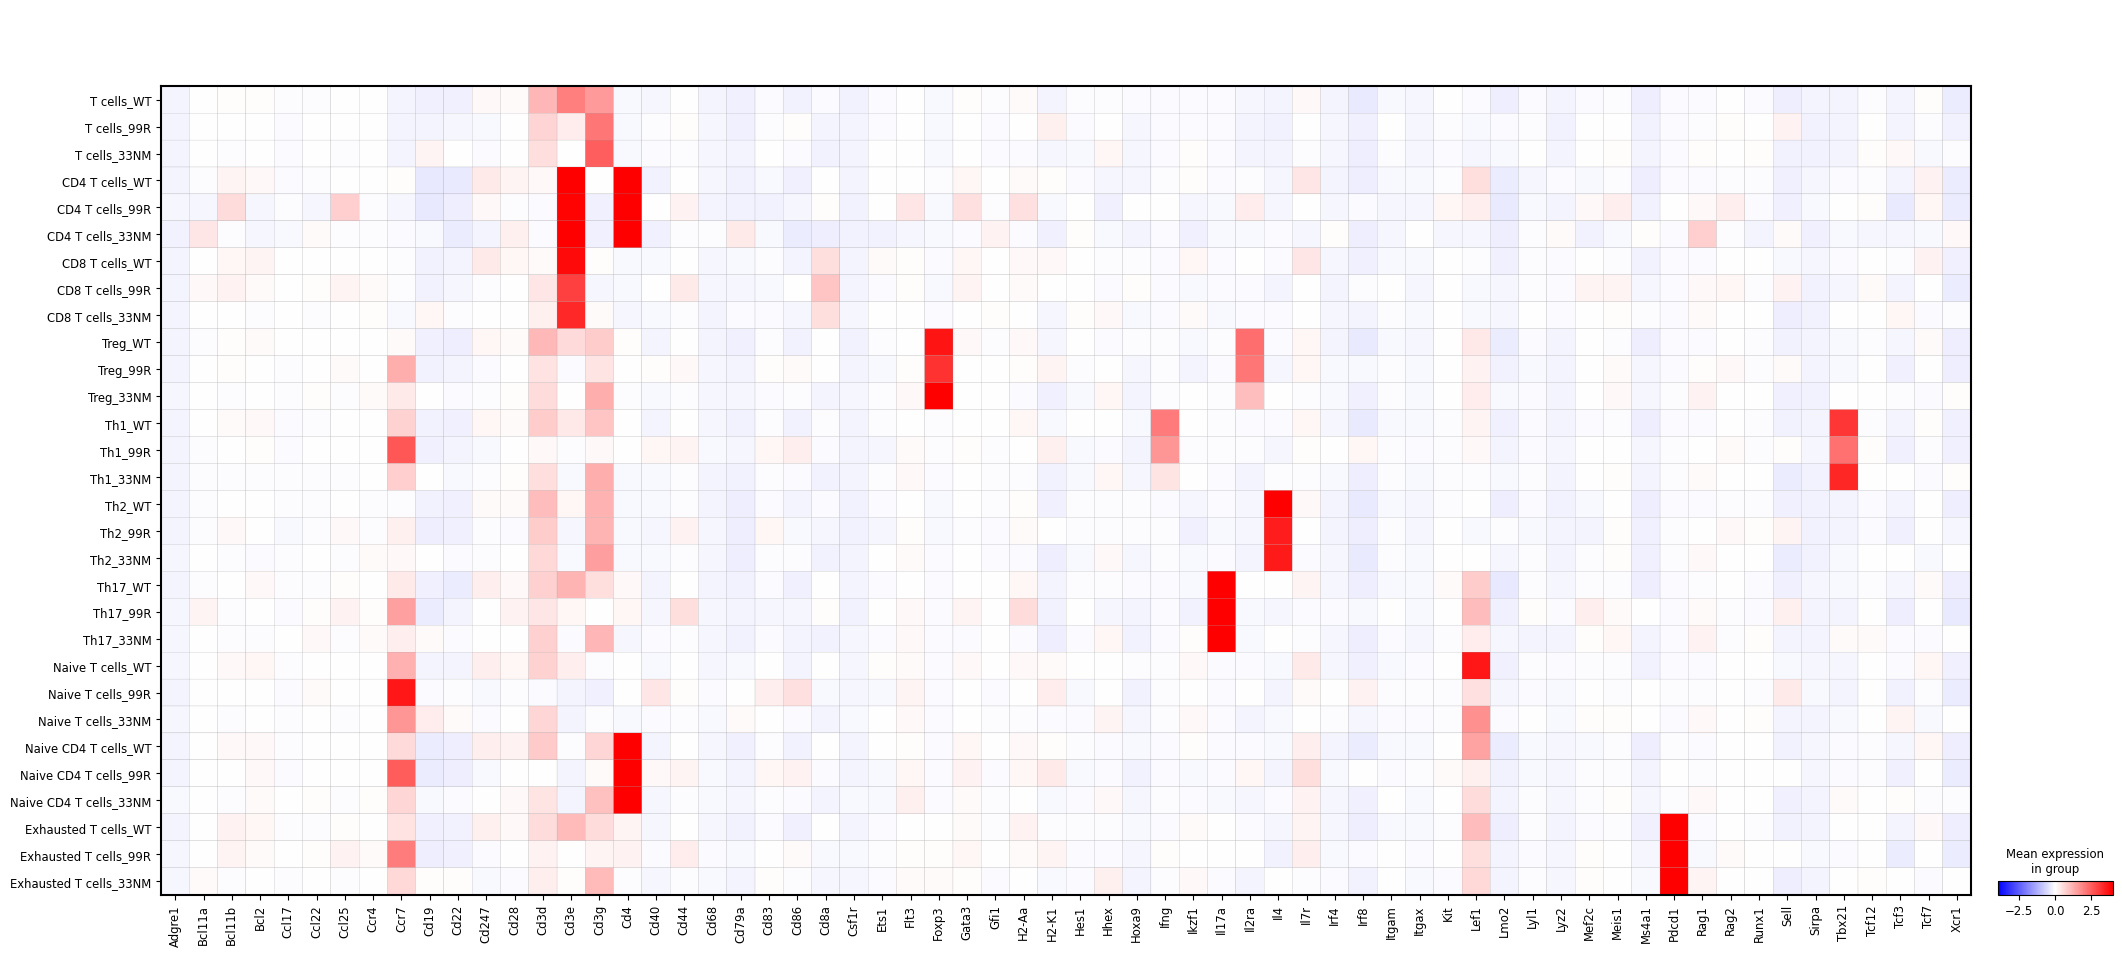

Macrophages


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\scanpy\plotting\_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


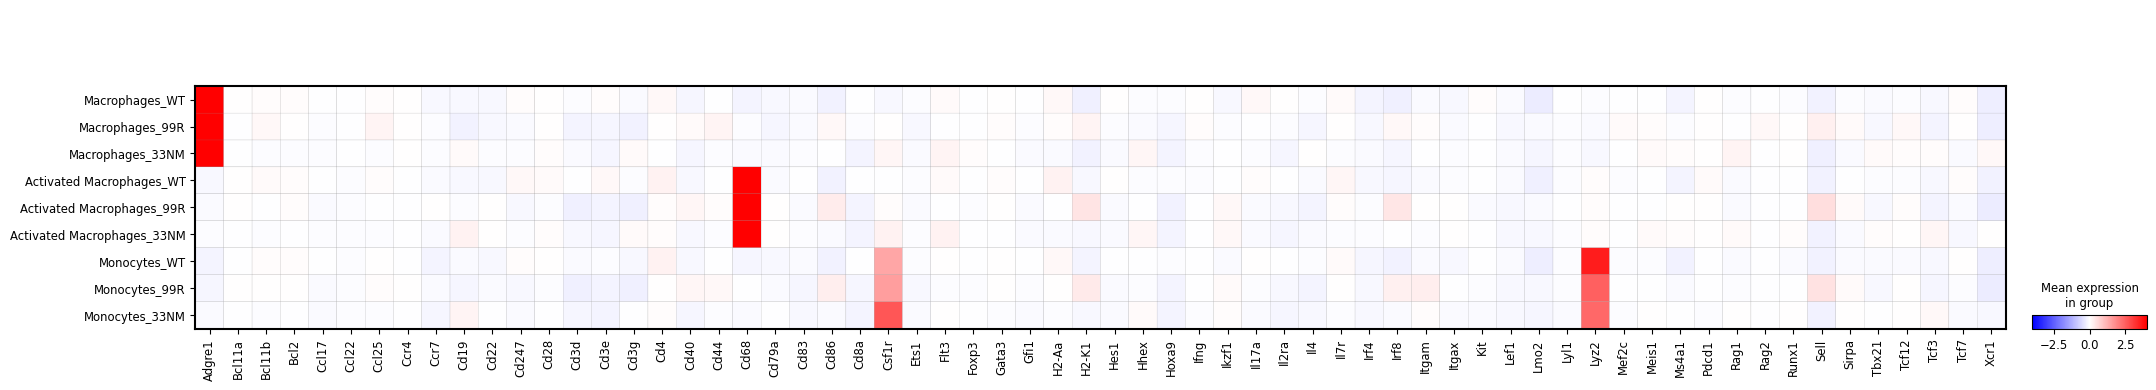

Dendritic cells


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\scanpy\plotting\_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


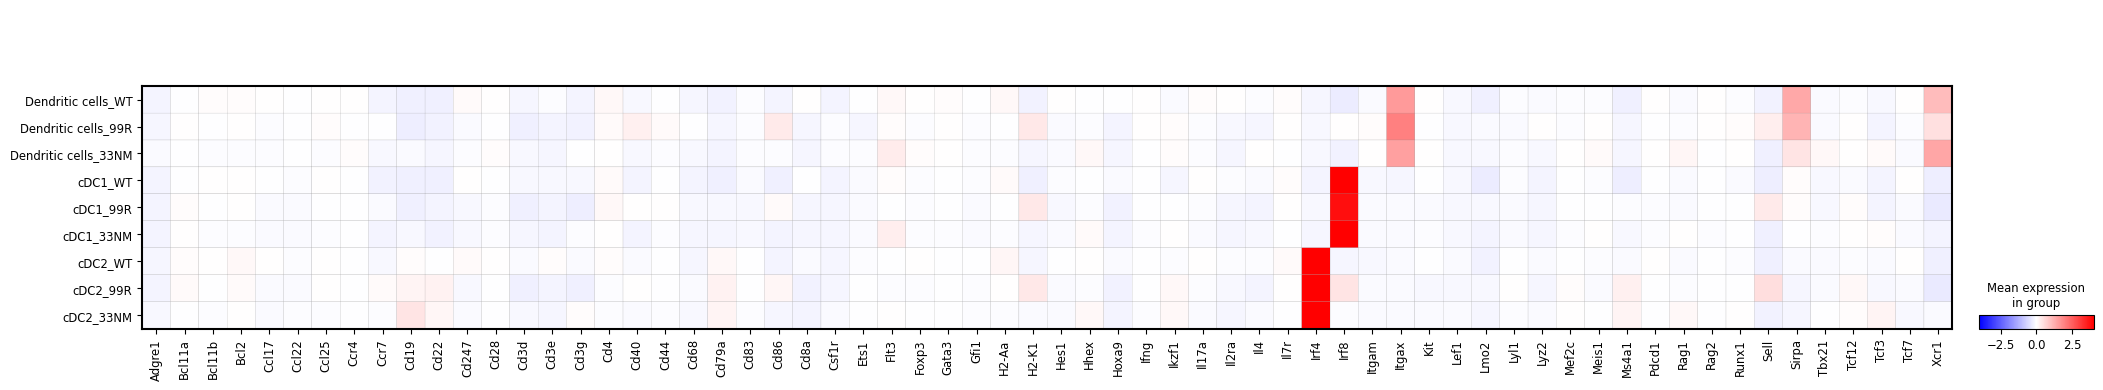

In [6]:
for current_level_1 in rdata.obs['level_1'].unique():
    if current_level_1 != 'NA':
        print(current_level_1)
        current_adata = rdata[rdata.obs['level_1'] == current_level_1, ]
        sc.pl.matrixplot(current_adata, current_adata.var.index, groupby=f'level_2_condition', dendrogram=False, use_raw=False, cmap='bwr', vmin=-4, vmax=4, swap_axes=False)

## Spatial analysis

### 2D

In [130]:
spatia2d = rdata.obs.loc[:, ['global_x', 'global_y']].values
spatia2d = spatia2d * [0.194, 0.194]

rdata.obsm['spatial'] = spatia2d

In [131]:
adata_list = [rdata[(rdata.obs['sample'] == i) & (rdata.obs['level_2'] != 'NA'), ] for i in rdata.obs['sample'].cat.categories]

#### WT

In [132]:
wt_adata = ad.concat([adata_list[0], adata_list[1]], uns_merge="same")
wt_adata

AnnData object with n_obs × n_vars = 330628 × 64
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'unique_index', 'region', 'condition', 'level_1', 'level_2', 'level_2_condition'
    obsm: 'spatial'
    layers: 'scaled'

In [133]:
sq.gr.spatial_neighbors(wt_adata, library_key='sample', coord_type="generic", delaunay=True, percentile=99)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.91/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


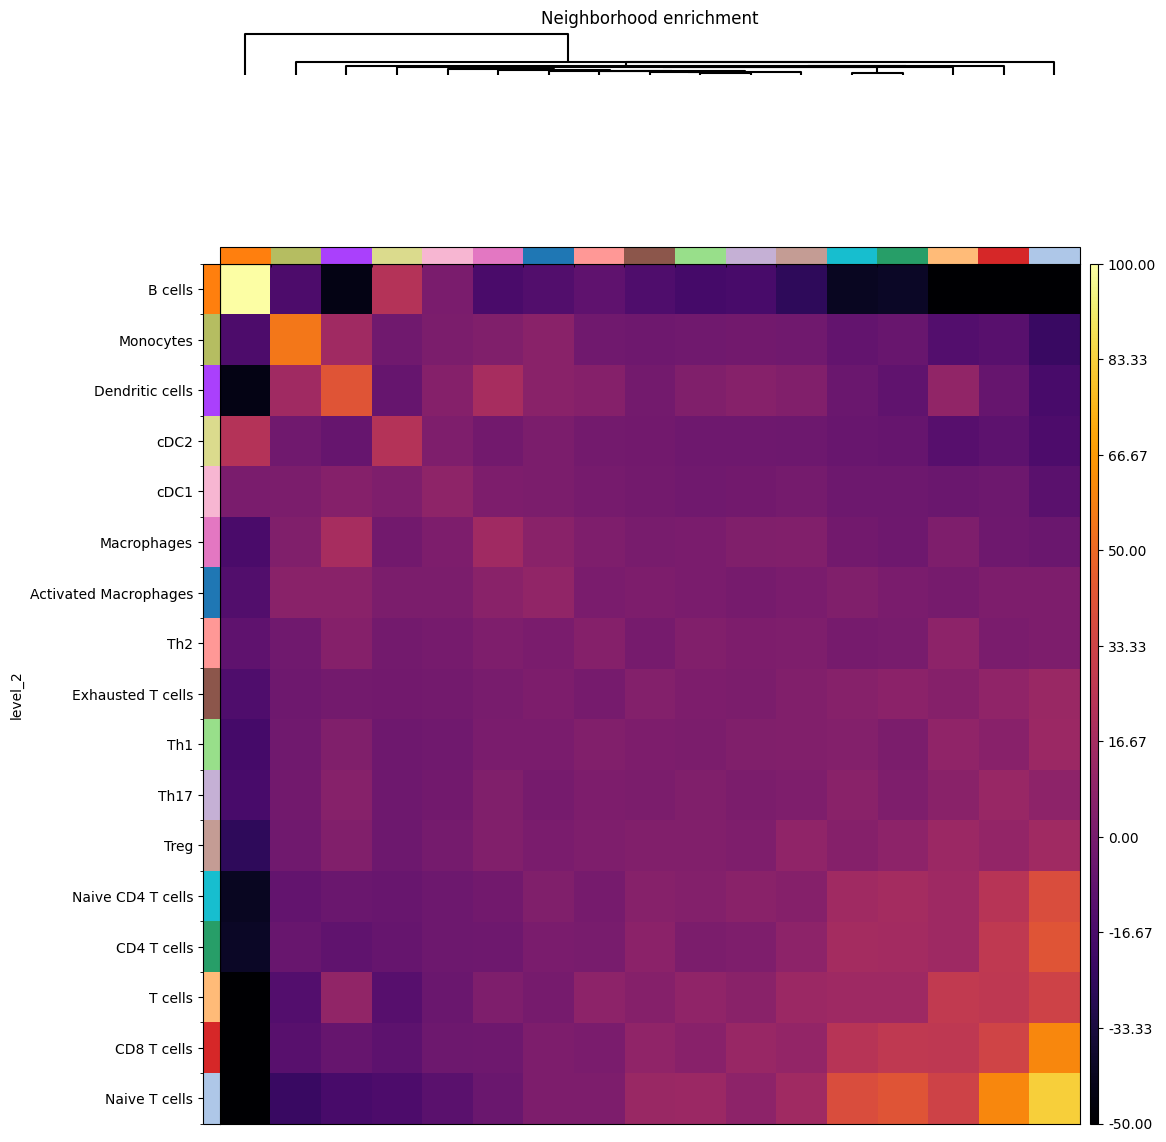

In [134]:
sq.gr.nhood_enrichment(wt_adata, cluster_key="level_2")
sq.pl.nhood_enrichment(
    wt_adata, cluster_key="level_2", method="single", cmap="inferno", vmin=-50, vmax=100
)

C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packa

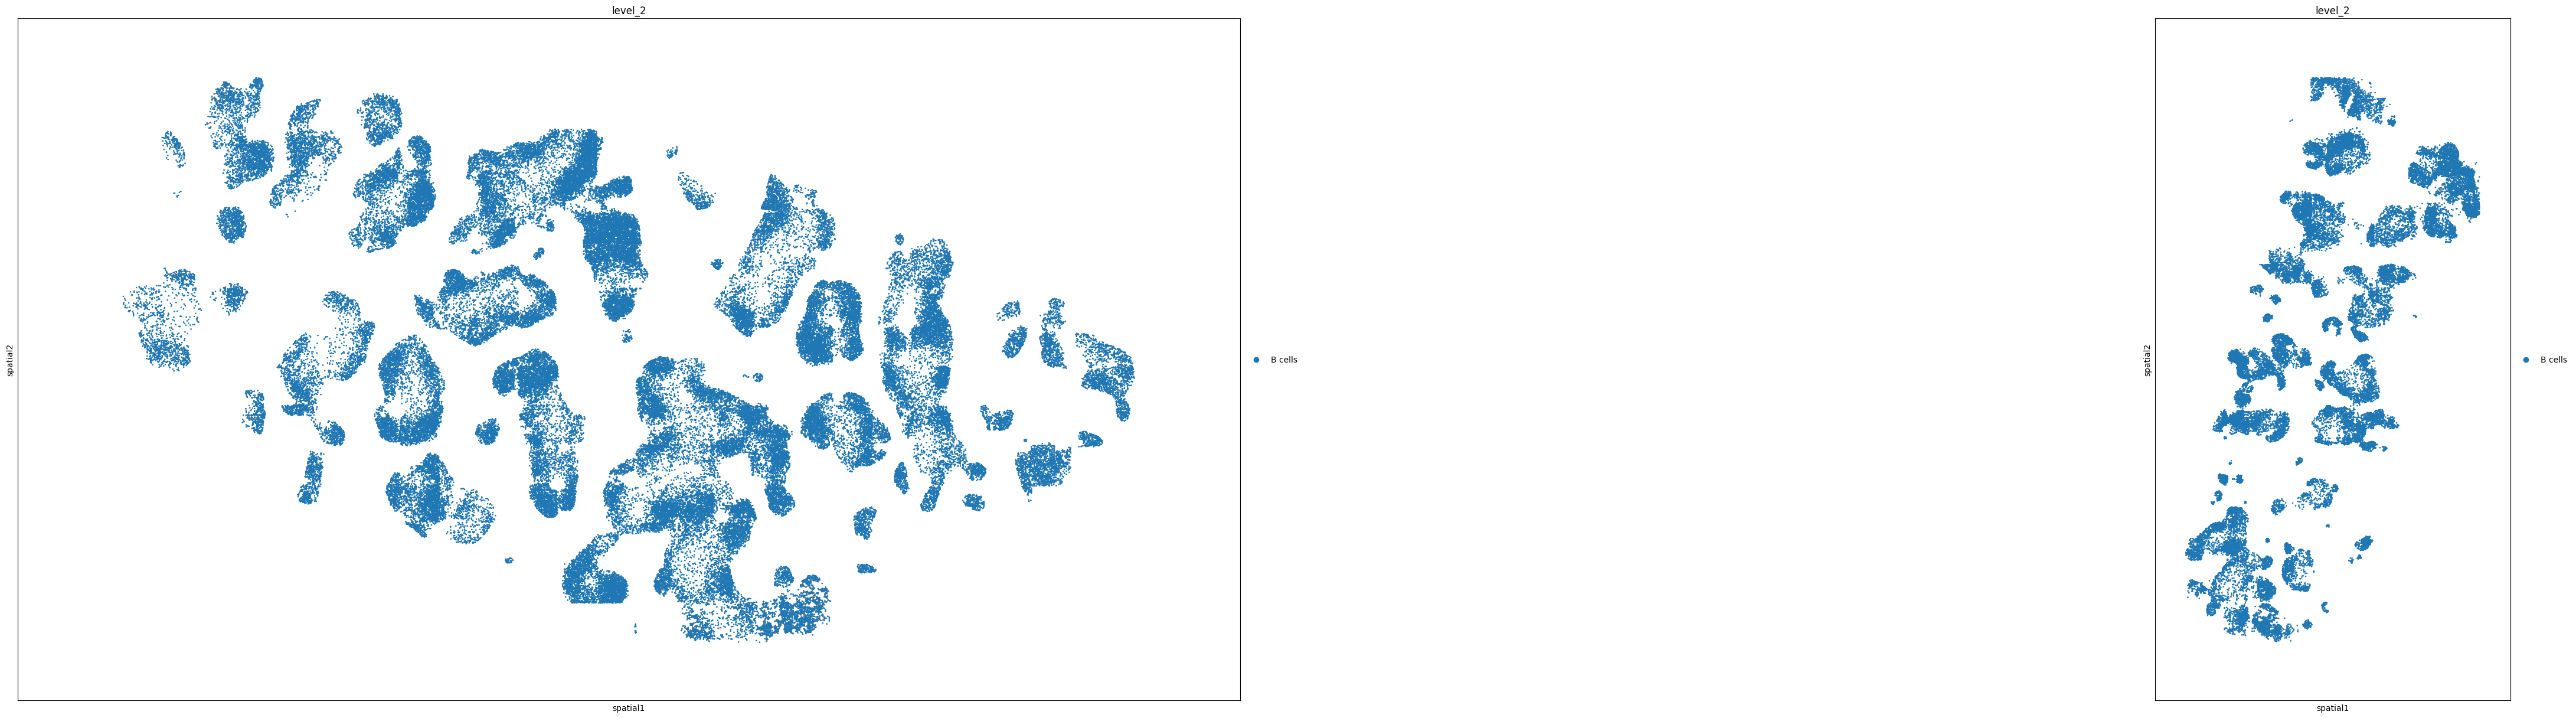

In [140]:
sq.pl.spatial_scatter(
    wt_adata,
    color="level_2",
    library_key='sample',
    groups=[
        'B cells'
        # "Naive T cells",
        # "Naive CD4 T cells",
        # "CD4 T cells",
        # "CD8 T cells",
        # "T cells",
    ],
    shape=None,
    size=2,
    palette='tab10',
    figsize=(30, 15),
connectivity_key='spatial_connectivities',
)

In [141]:
sq.gr.co_occurrence(wt_adata, cluster_key="level_2")
sq.pl.co_occurrence(
    wt_adata,
    cluster_key="level_2",
    figsize=(10, 5),
)

  1%|█▊                                                                                                                                  | 178/13203 [02:06<2:19:09,  1.56/s]

KeyboardInterrupt: 

#### 99R

In [143]:
r99_adata = ad.concat([adata_list[2], adata_list[3]], uns_merge="same")
r99_adata

AnnData object with n_obs × n_vars = 451480 × 64
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'unique_index', 'region', 'condition', 'level_1', 'level_2', 'level_2_condition'
    obsm: 'spatial'
    layers: 'scaled'

In [144]:
sq.gr.spatial_neighbors(r99_adata, library_key='sample', coord_type="generic", delaunay=True, percentile=99)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.40/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


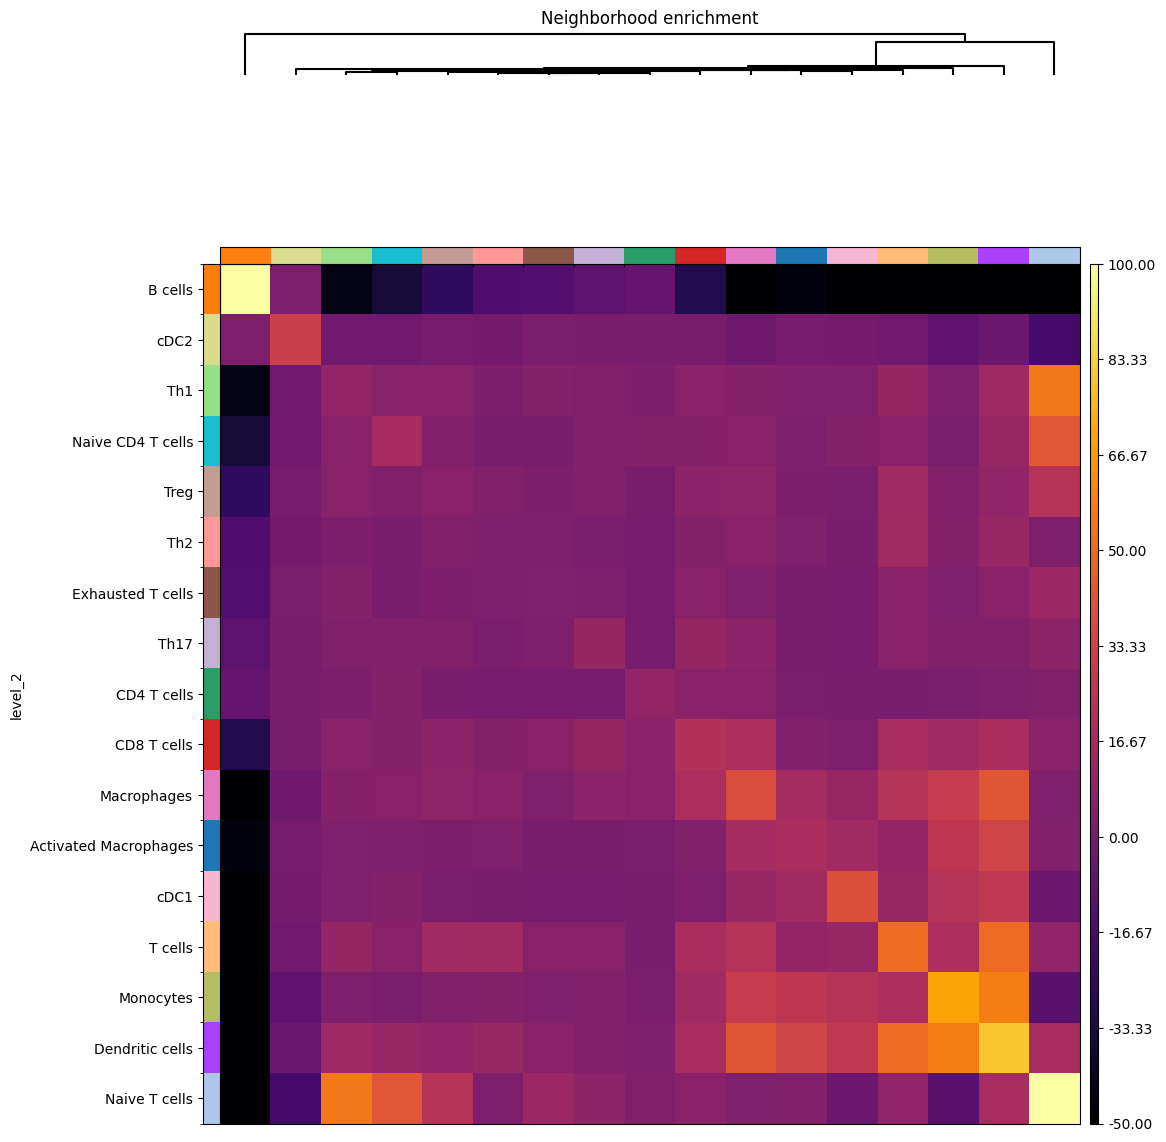

In [145]:
sq.gr.nhood_enrichment(r99_adata, cluster_key="level_2")
sq.pl.nhood_enrichment(
    r99_adata, cluster_key="level_2", method="single", cmap="inferno", vmin=-50, vmax=100
)

C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packa

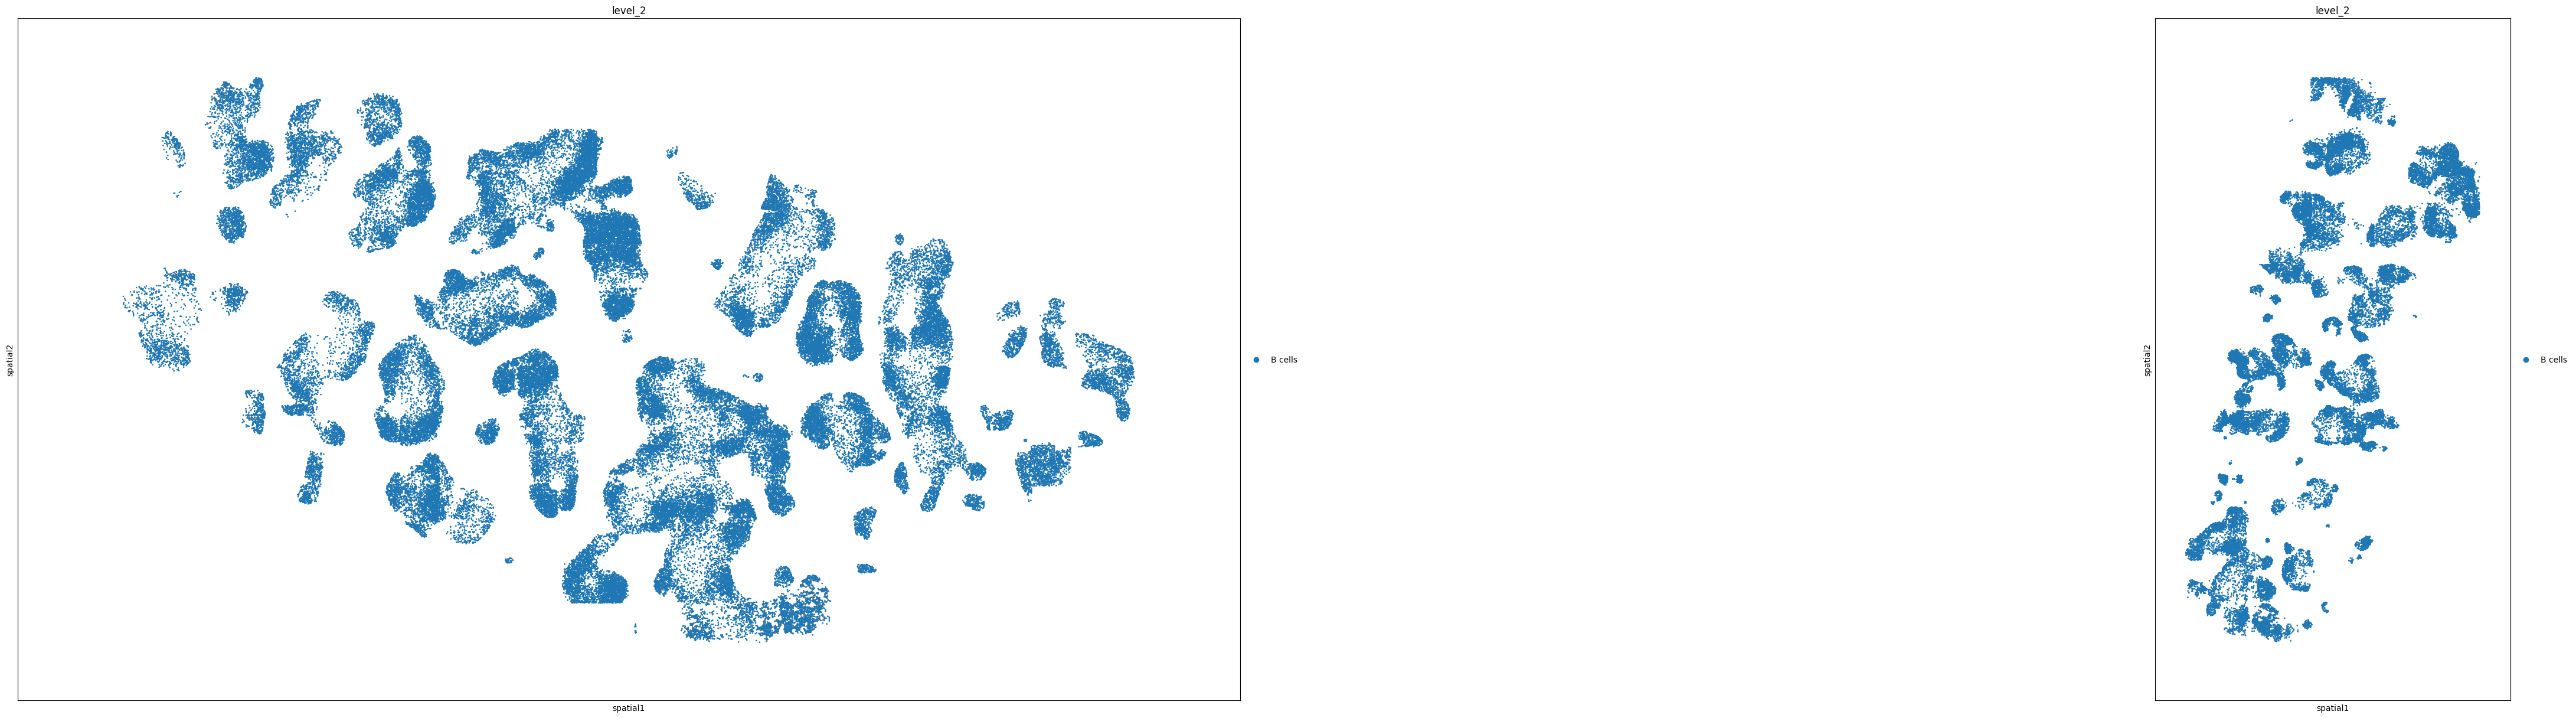

In [140]:
sq.pl.spatial_scatter(
    r99_adata,
    color="level_2",
    library_key='sample',
    groups=[
        'B cells'
        # "Naive T cells",
        # "Naive CD4 T cells",
        # "CD4 T cells",
        # "CD8 T cells",
        # "T cells",
    ],
    shape=None,
    size=2,
    palette='tab10',
    figsize=(30, 15),
connectivity_key='spatial_connectivities',
)

#### 33NM

In [148]:
n33_adata = ad.concat([adata_list[4], adata_list[5]], uns_merge="same")
n33_adata

AnnData object with n_obs × n_vars = 334435 × 64
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'unique_index', 'region', 'condition', 'level_1', 'level_2', 'level_2_condition'
    obsm: 'spatial'
    layers: 'scaled'

In [149]:
sq.gr.spatial_neighbors(n33_adata, library_key='sample', coord_type="generic", delaunay=True, percentile=99)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.16/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


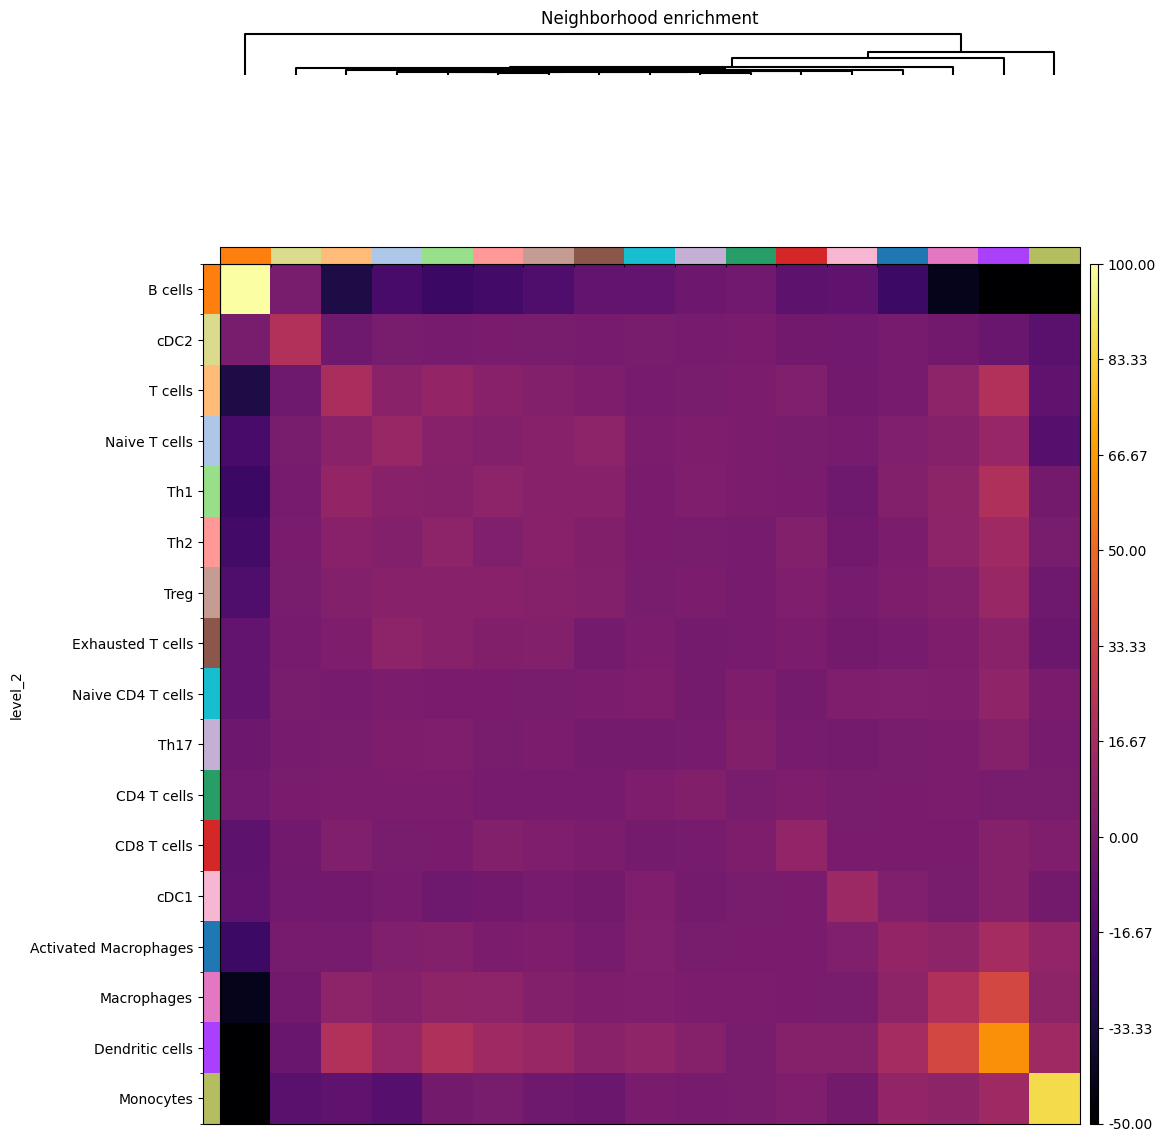

In [150]:
sq.gr.nhood_enrichment(n33_adata, cluster_key="level_2")
sq.pl.nhood_enrichment(
    n33_adata, cluster_key="level_2", method="single", cmap="inferno", vmin=-50, vmax=100
)

C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packa

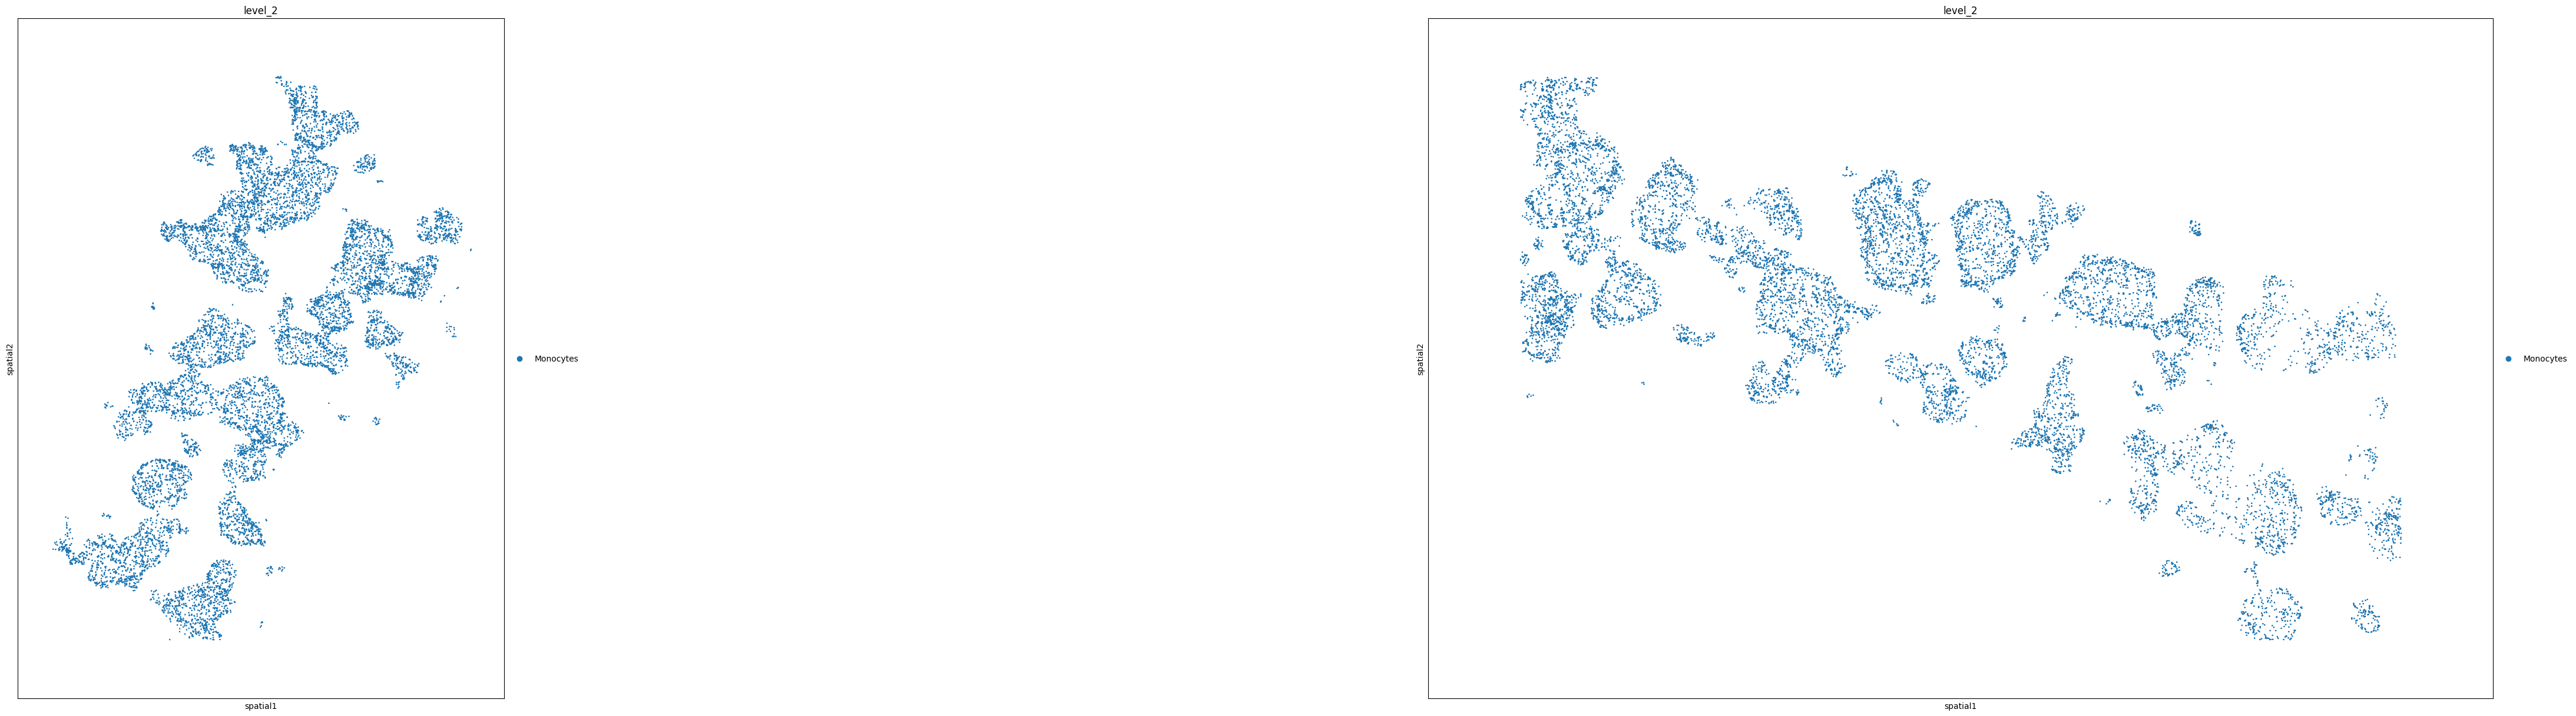

In [151]:
sq.pl.spatial_scatter(
    n33_adata,
    color="level_2",
    library_key='sample',
    groups=[
        'Monocytes'
        # "Naive T cells",
        # "Naive CD4 T cells",
        # "CD4 T cells",
        # "CD8 T cells",
        # "T cells",
    ],
    shape=None,
    size=2,
    palette='tab10',
    figsize=(30, 15),
connectivity_key='spatial_connectivities',
)

#### each sample

In [ ]:
for i in range(len(adata_list)):
    print(adata_list[i].obs['sample'].unique())

    sq.gr.spatial_neighbors(adata_list[i], coord_type="generic", delaunay=True, percentile=99)
    sq.gr.nhood_enrichment(adata_list[i], cluster_key="level_2")
    sq.pl.nhood_enrichment(
        adata_list[i], cluster_key="level_2", method="single", cmap="inferno", vmin=-50, vmax=100
    )

In [101]:
dist = adata_list[5].obsp['spatial_distances'].data
nf_log = ~np.isfinite(dist)
dist[nf_log]

array([], dtype=float64)

In [100]:
~np.isfinite(adata_list[5].obsp['spatial_distances'].data)

array([False, False, False, ..., False, False, False])

In [94]:
for i in range(len(adata_list)):
    print(np.percentile(adata_list[i].obsp['spatial_distances'].data, 99))

14.877409586346099
25.992727754536745
15.153126278105024
14.663371644998264
13.668398003952728
18.43102102439801


In [75]:
for i in range(len(adata_list_3d)):
    print(np.percentile(adata_list_3d[i].obsp['spatial_distances'].data, 90))

23.36865712884362
32.55538966129077
23.3486072389288
23.079990121381183
23.437897857785952
26.746878845946338


<Axes: ylabel='Count'>

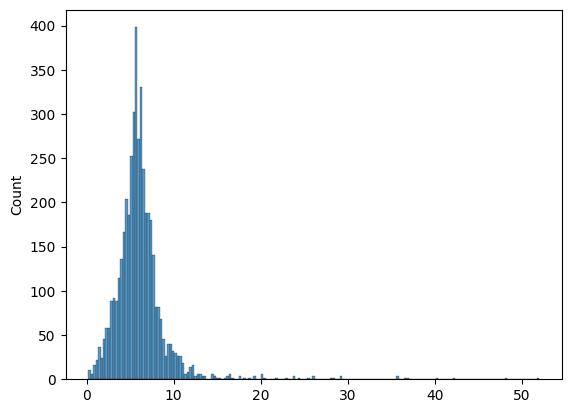

In [88]:
sns.histplot(viz_adata.obsp['spatial_distances'].data)

C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


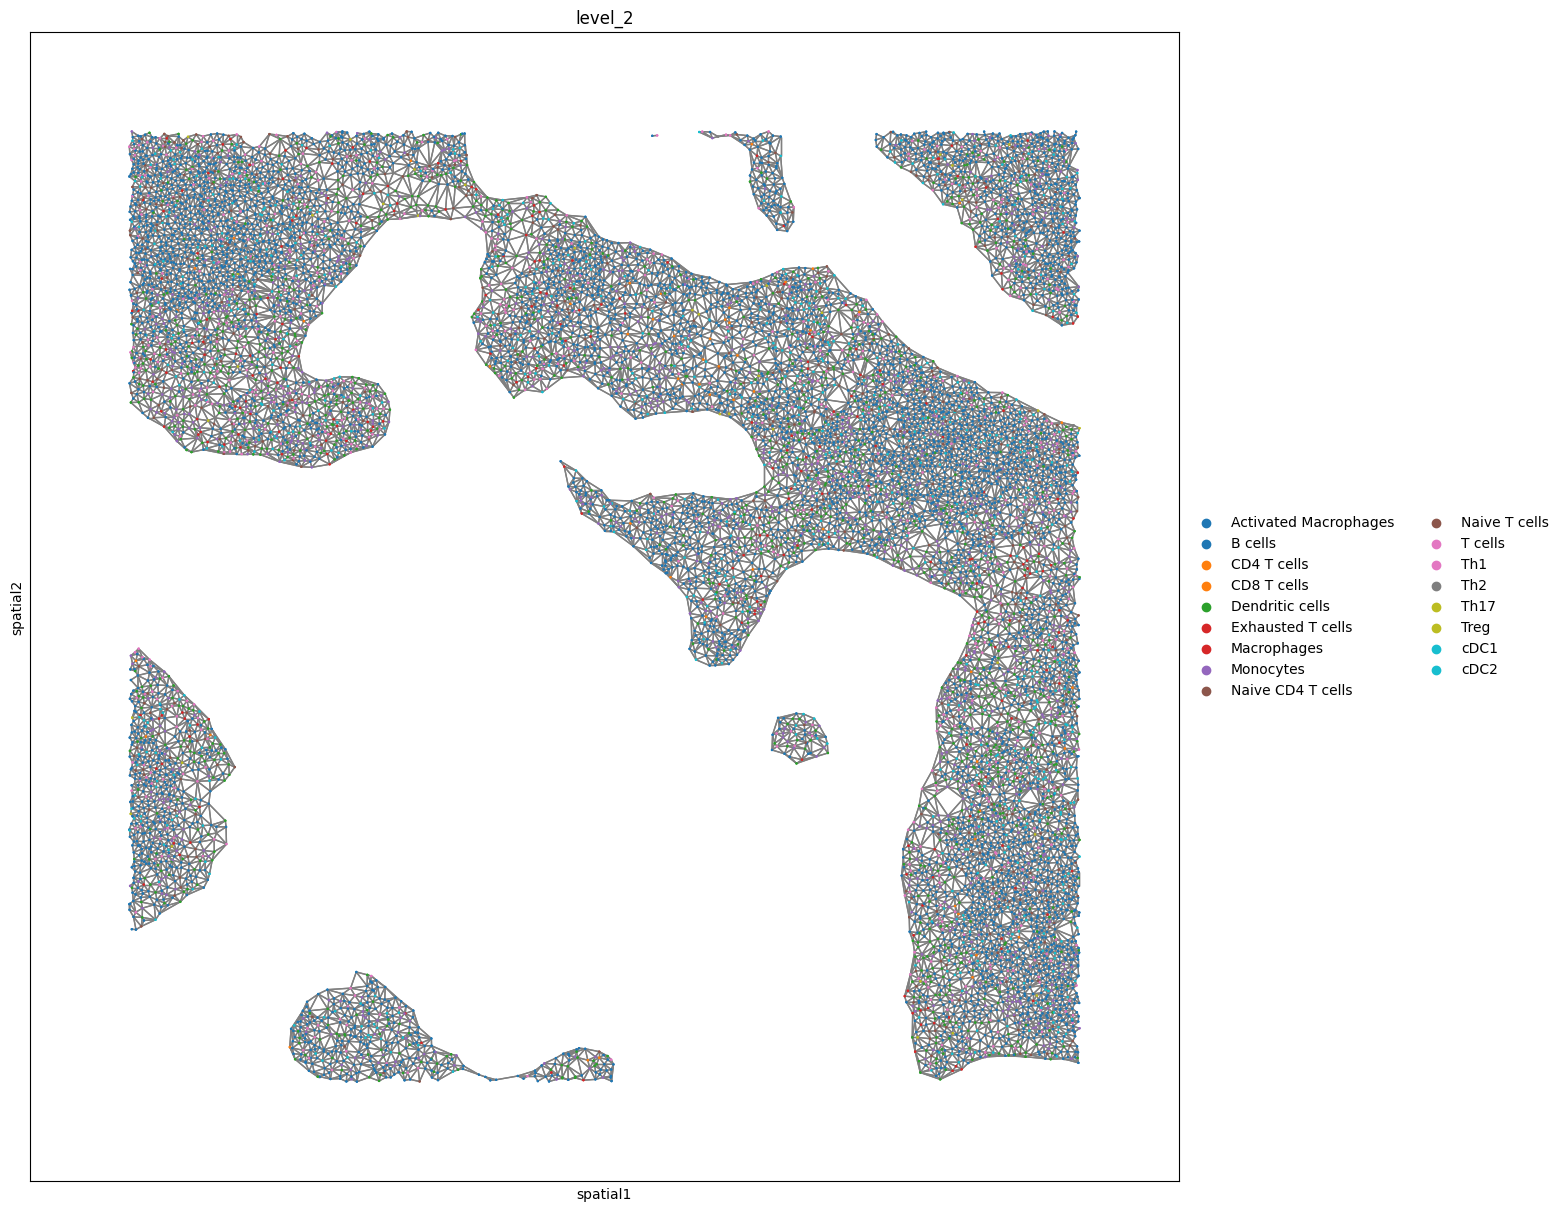

In [96]:
viz_adata = adata_list[5].copy()
viz_adata = viz_adata[(viz_adata.obs['global_x'].isin(range(5000, 10000))) & (viz_adata.obs['global_y'].isin(range(5000, 10000))), :]

# sq.gr.spatial_neighbors(viz_adata, coord_type="generic", delaunay=True)
sq.pl.spatial_scatter(
    viz_adata,
    color="level_2",
    # groups=[
    #     "Dendritic cells",
    #     "T cells",
    # ],
    shape=None,
    size=2,
    palette='tab10',
    figsize=(24, 12),
    connectivity_key='spatial_connectivities',
)

### 3D

In [10]:
spatia3d = rdata.obs.loc[:, ['global_x', 'global_y', 'global_z']].values
spatia3d = spatia3d * [0.194, 0.194, 0.346]

rdata.obsm['spatial'] = spatia3d

In [11]:
adata_list_3d = [rdata[(rdata.obs['sample'] == i) & (rdata.obs['level_2'] != 'NA'), ] for i in rdata.obs['sample'].cat.categories]

['sample1']
Categories (1, object): ['sample1']


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\gr\_utils.py:200: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.91/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


['sample2']
Categories (1, object): ['sample2']


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\gr\_utils.py:200: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.63/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


['sample3']
Categories (1, object): ['sample3']


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\gr\_utils.py:200: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.82/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


['sample4']
Categories (1, object): ['sample4']


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\gr\_utils.py:200: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.21/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


['sample5']
Categories (1, object): ['sample5']


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\gr\_utils.py:200: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.16/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


['sample6']
Categories (1, object): ['sample6']


C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\gr\_utils.py:200: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.04/s]
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\jiahao\.conda\envs\sc_39\lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


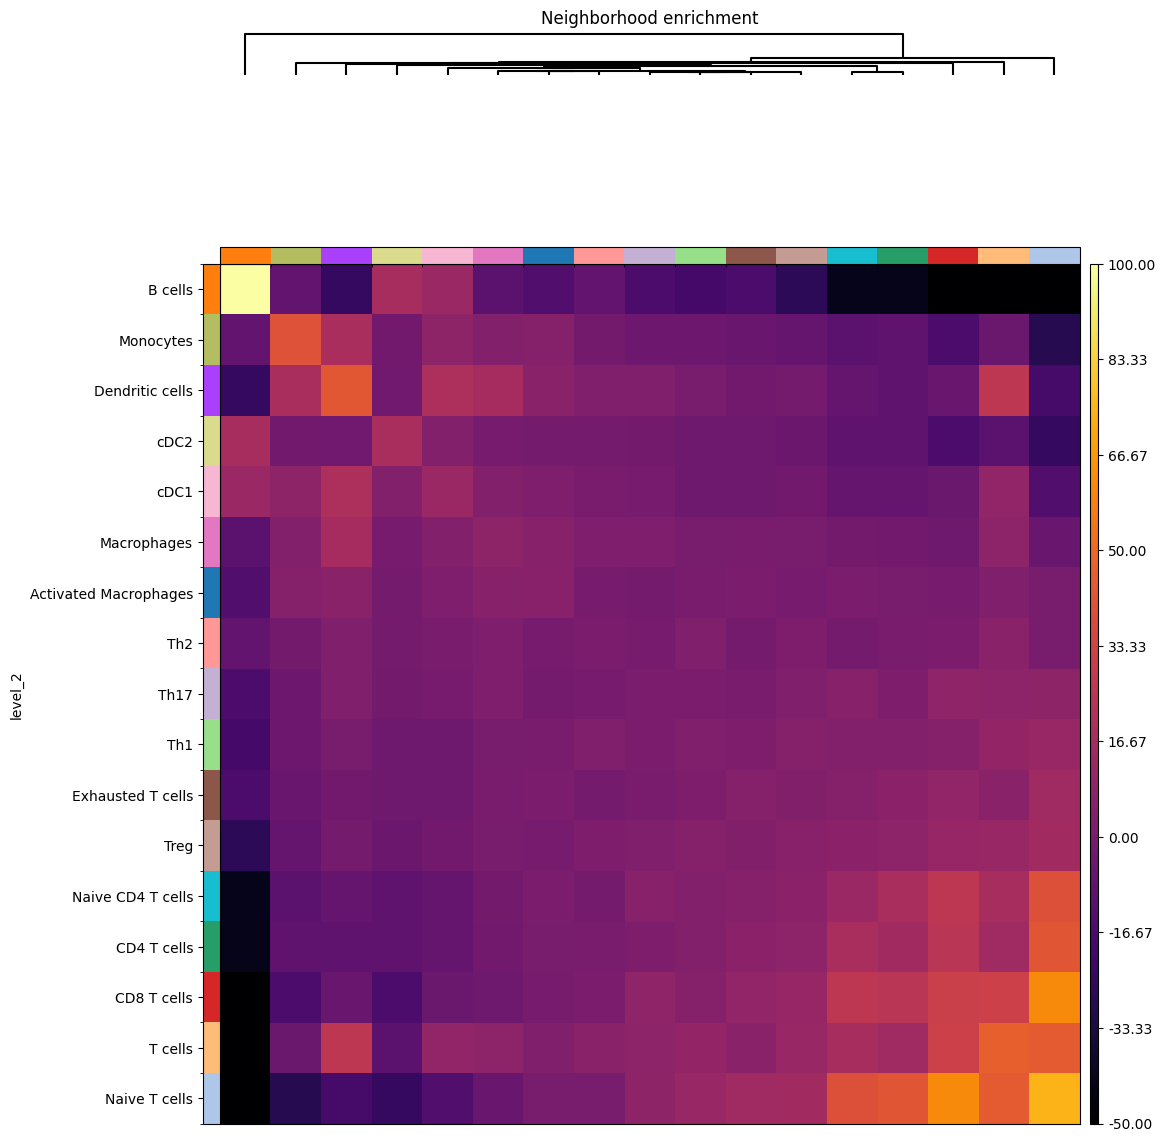

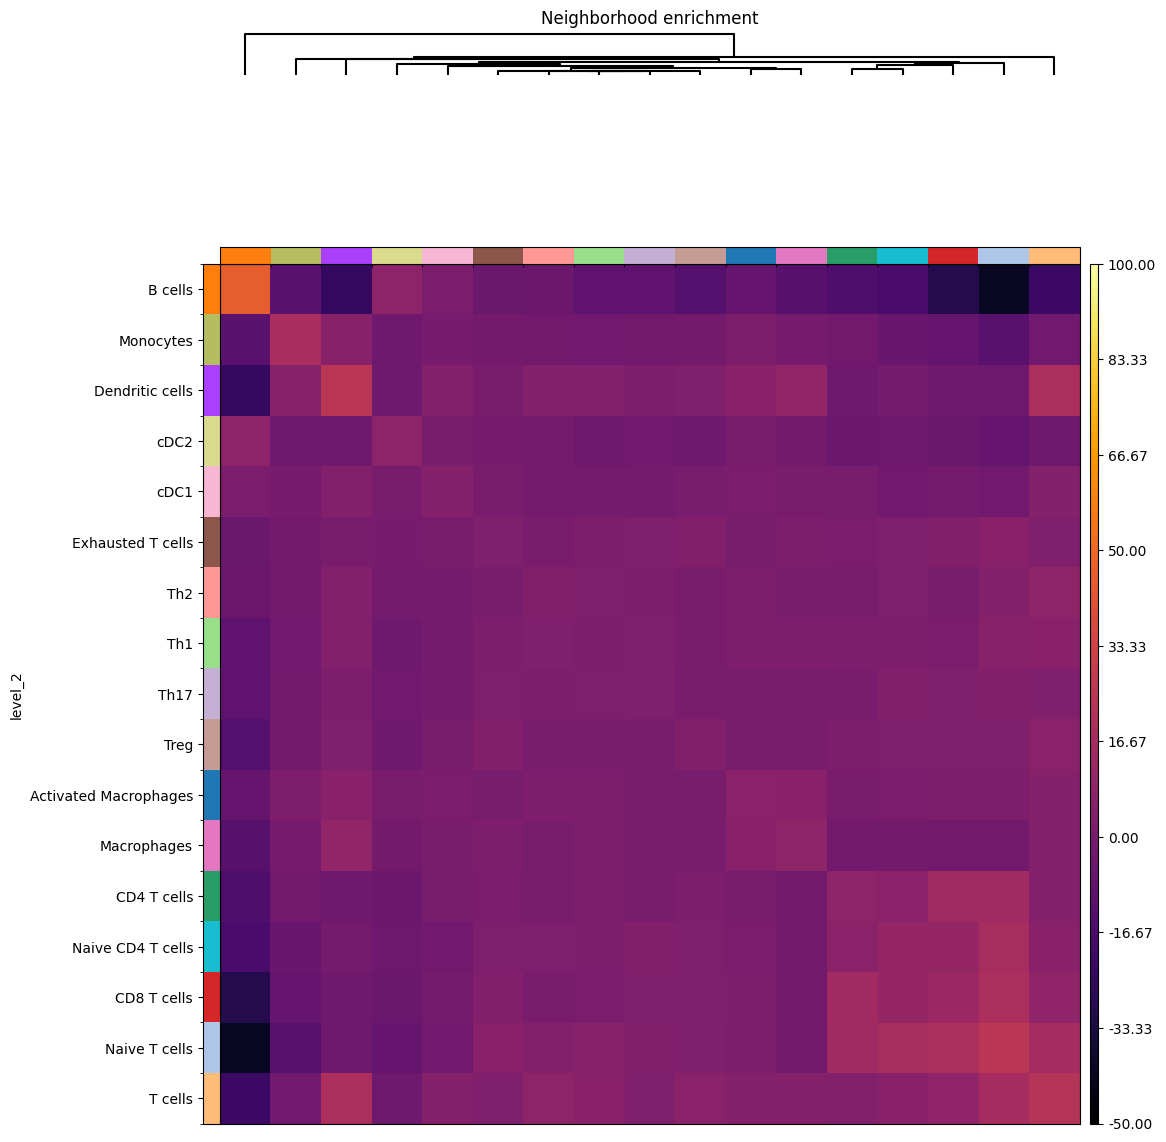

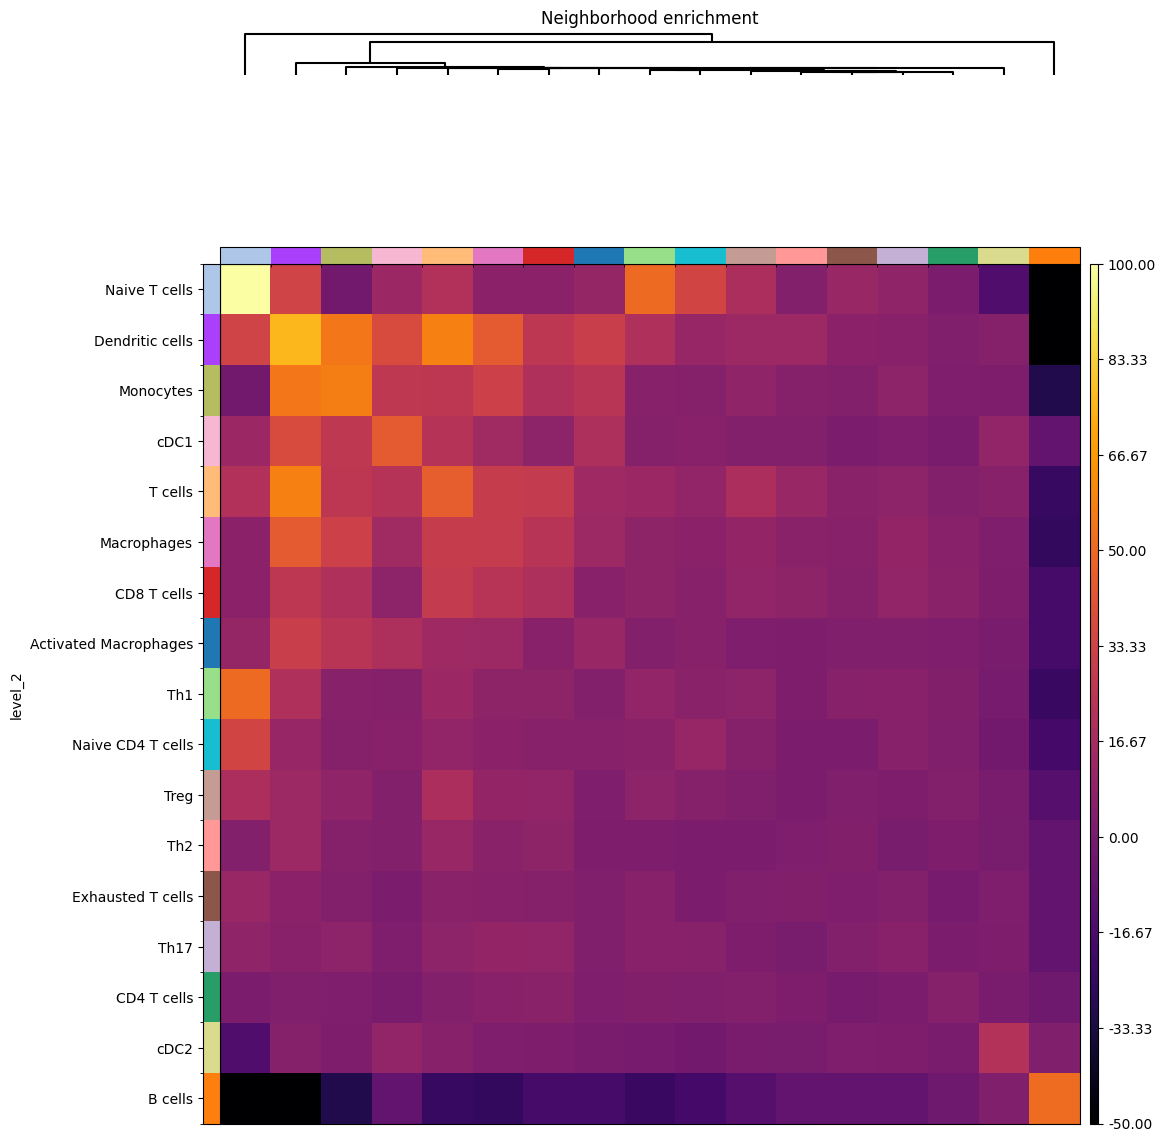

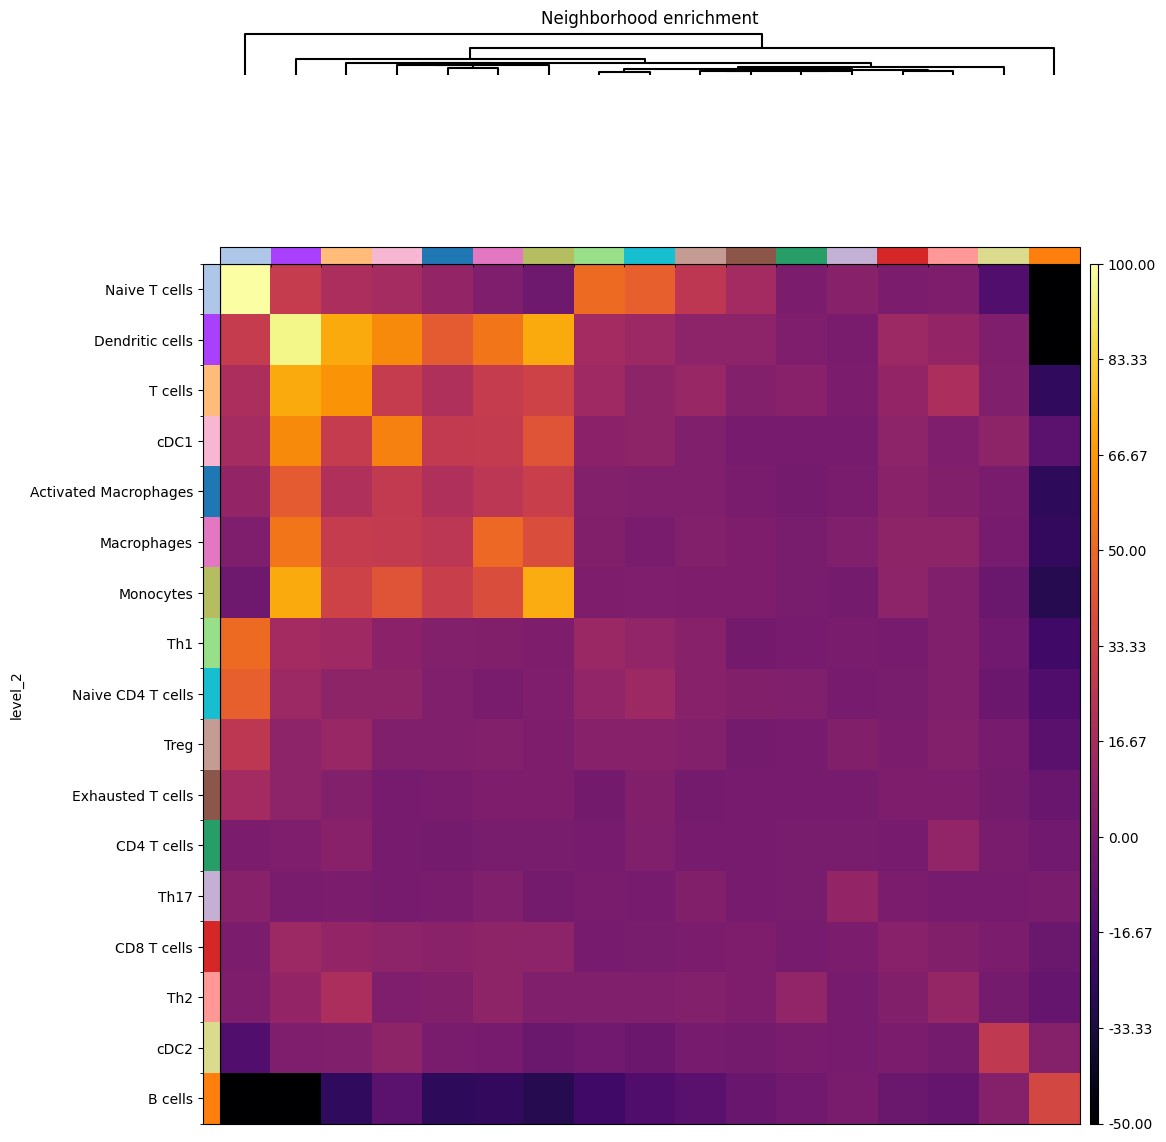

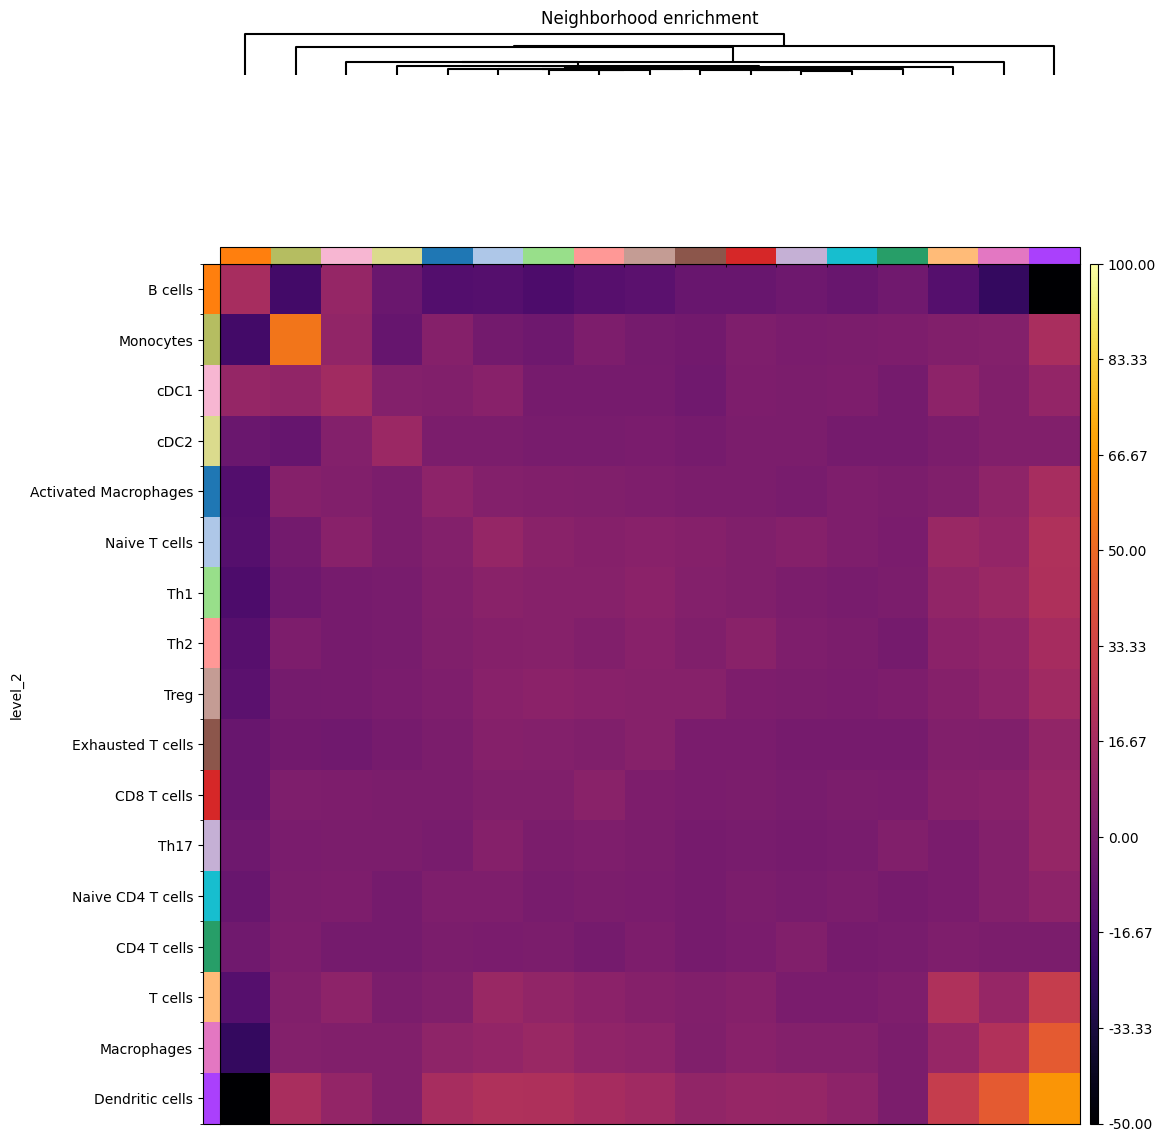

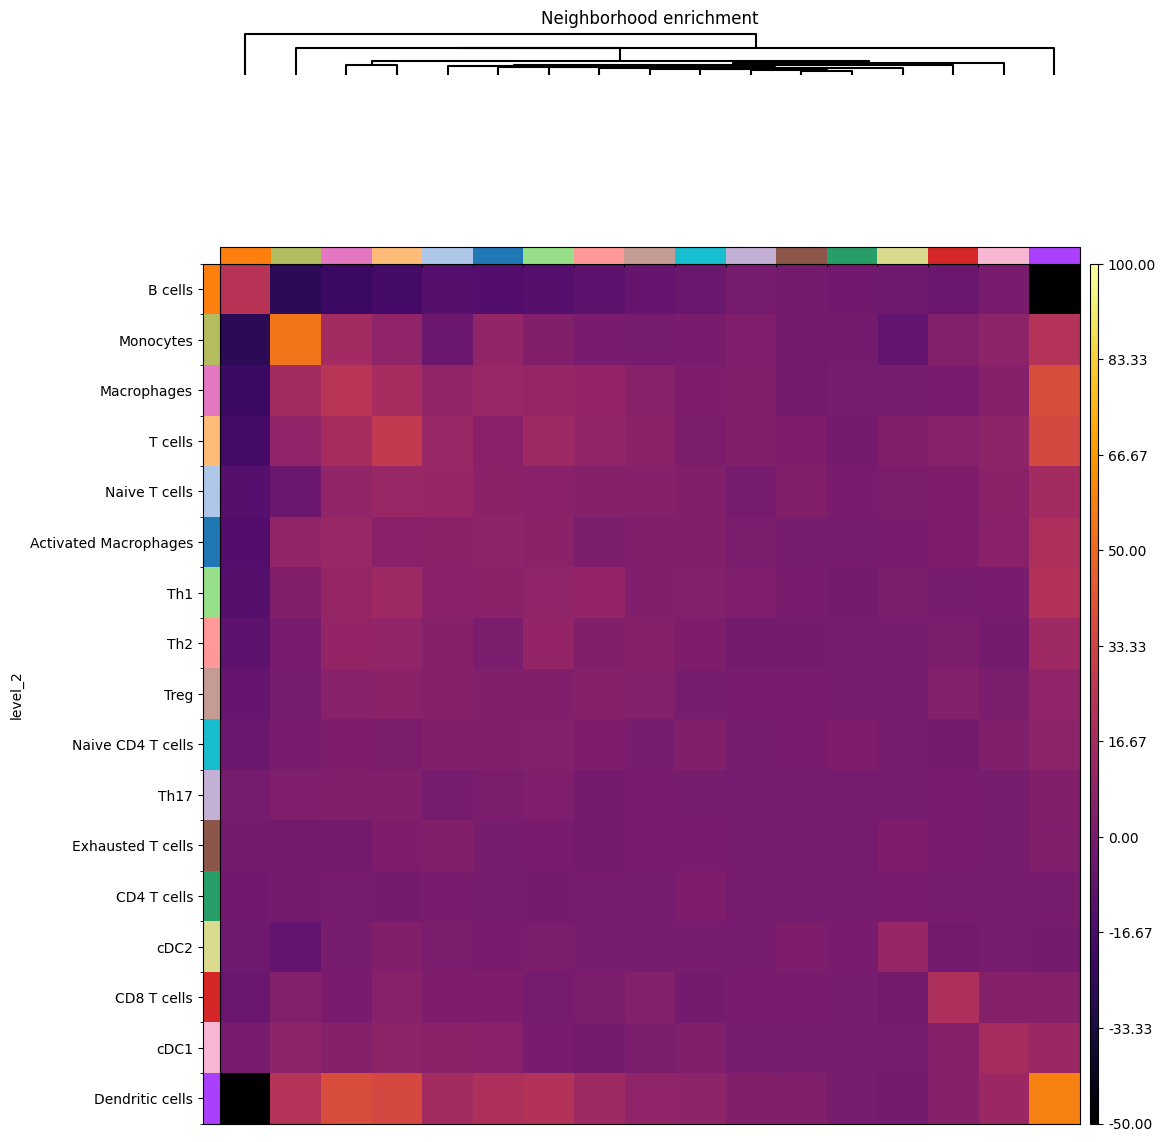

In [12]:
for i in range(len(adata_list_3d)):
    print(adata_list_3d[i].obs['sample'].unique())

    sq.gr.spatial_neighbors(adata_list_3d[i], coord_type="generic", delaunay=True, percentile=90)
    sq.gr.nhood_enrichment(adata_list_3d[i], cluster_key="level_2")
    sq.pl.nhood_enrichment(
        adata_list_3d[i], cluster_key="level_2", method="single", cmap="inferno", vmin=-50, vmax=100
    )